# Beat Tracking

## Imports

In [1]:
import os
import librosa
import librosa.display
import IPython.display as ipd
from matplotlib import pyplot as plt
import numpy as np

from scipy.signal import medfilt as medfilt
from scipy.ndimage import maximum_filter1d as maxfilt

from sklearn.cluster import KMeans
from collections import Counter

import mir_eval

## Loading a file

First applying and demonstrating the pipeline for one file with visualization, towards the end will run for a set of files for a generalized evaluation

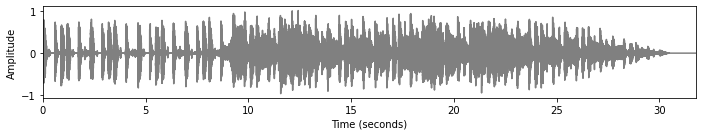

In [2]:
path_data = '../ballroom-data/'

# For now just testing with one
audio_file = path_data+'/Rumba-International/Media-105611.wav'

# Load audio
x, sr = librosa.load(os.path.join(audio_file))  # sampled at a rate of 22050 Hz
ipd.display(ipd.Audio(x,rate=sr))

# Plot audio
t1 = np.arange(x.shape[0]) / sr
plt.figure(figsize=(10, 2))
plt.plot(t1, x, color='gray')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim([t1[0], t1[-1]])
plt.tight_layout()

## Onset Detection

[0.0,
 0.5804988662131519,
 0.8591383219954649,
 1.1609977324263039,
 1.7414965986394557,
 2.2987755102040817,
 2.8792743764172335,
 3.1811337868480725,
 3.4597732426303858,
 4.040272108843538]

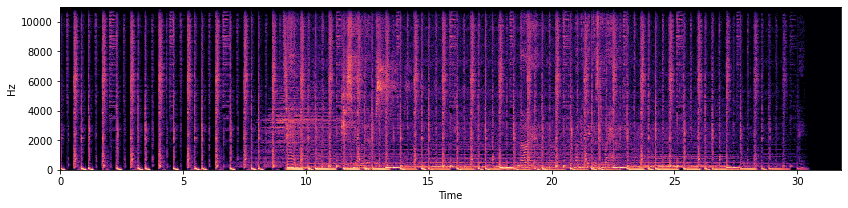

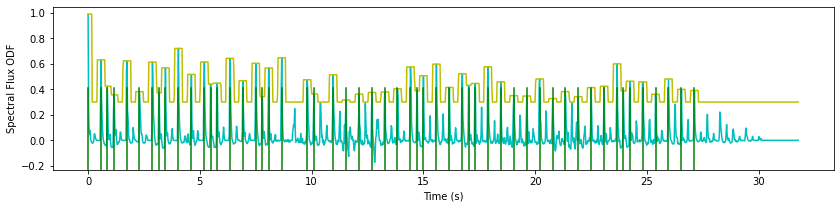

In [10]:
n = 2048
window = 'hann'
hop_length = 512

width = 15
threshold= 0.3

def detect_onsets(x, width, threshold, plot=False):
    # Short Fast Fourier Transform for spectrogram of audio
    D = np.abs(librosa.stft(x, window=window, hop_length=hop_length))  # STFT
    D_transp = D.transpose()
    
    # Initialise variables for iterating
    frames = len(D_transp)
    odf = np.zeros(frames)  # stores odf spectral values for insinuating onsets
    bins = len(D)
    prev_magnitude = np.zeros(bins)  # stores magnitude of previous frame
    
    # Iterate through frames, process data via spectral flux
    for i, frame in enumerate(D_transp):
        magnitude = np.abs(frame)
        
        has_greater_magnitude = np.greater(magnitude, prev_magnitude)
        diff_magnitude = np.subtract(magnitude, prev_magnitude)
        
        spectral_flux = np.mean(np.multiply(has_greater_magnitude, diff_magnitude))
        odf[i] = spectral_flux
        
        prev_magnitude = magnitude
        
    # Normalise with respect to maximum odf value
    mx = max(odf)
    if mx > 0: odf /= mx
        
    # Computing peak times by filtering and thresholding
    hop_time = hop_length / sr
    t = np.arange(len(odf)) * hop_time
    odf_med = odf - medfilt(odf, width)
    odf_max = maxfilt(odf_med, width, mode='nearest', axis=0)
    
    thresholds = [max(i, threshold) for i in odf_max]
    peak_args = np.nonzero(np.greater_equal(odf_med, thresholds))
    peak_times = peak_args[0] * hop_time
    
    if plot:
        plt.figure(figsize=(14, 3))
        librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='linear', x_axis='time')
        
        plt.figure(figsize=(14, 3))
        plt.xlabel('Time (s)')
        plt.ylabel('Spectral Flux ODF')
        plt.plot(t, odf_med, 'c')
        plt.plot(t, thresholds, 'y')
        for p in peak_times:
           plt.axvline(p, ymax=0.5, color='g')
    
    return peak_times
    
onsets = detect_onsets(x, width=width, threshold=threshold, plot=True)
list(onsets[:10])

## IOI Clustering

[0.5805, 2.2988, 5.7585, 12.1208, 14.4196, 20.7819]

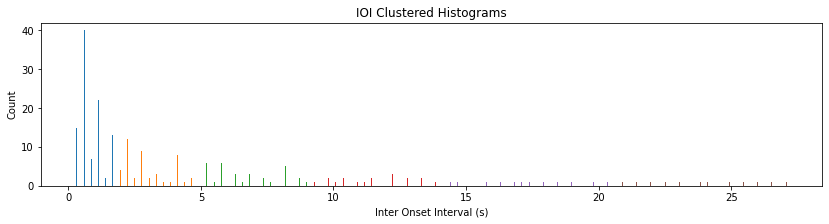

In [12]:
def ioi_clustering(onsets, n_clusters=6, plot=False):
    
    # Compute all possible inter onset intervals
    ioi = []
    for i in range(1, len(onsets)):
        for j in range(i, len(onsets), i):
            ioi.append(onsets[j] - onsets[j-i])

    temp = np.array(ioi).reshape(-1,1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(temp)
    
    # Construct clusters array and sort for convinience
    clusters = [[] for _ in range(n_clusters)]
    for i, label in enumerate(kmeans.labels_):
        clusters[label].append(ioi[i])
    clusters = sorted(clusters)
    
    if plot:
        plt.figure(figsize=(14, 3))
        plt.title('IOI Clustered Histograms')
        plt.xlabel('Inter Onset Interval (s)')
        plt.ylabel('Count')
        plt.hist(clusters, 100)  
    
    # Find the mode of each cluster
    ioi_common = []
    for clust in clusters:
        dict_counter = Counter()
        for x  in clust:
            dict_counter[round(x, 4)] += 1
    
        ioi_common.append(dict_counter.most_common()[0][0])
        
    return clusters, ioi_common
    
ioi_clusters, ioi_common = ioi_clustering(onsets, n_clusters= 6, plot=True)
ioi_common

## Periodicity function

In [13]:
# Compute tempos for each common IOI in terms of BPM
def ioi_to_tempo(ioi_common):
    return [60 / x for x in ioi_common]

# Compute ratios between common iois or tempos
def ratio_matrix(x):
    ratios = []
    for i in range(len(x)):
        ratios.append([])
        for j in range(len(x)):
            ratios[i].append(x[i]/x[j])
            
    return ratios

tempo = ioi_to_tempo(ioi_common)
ratios = ratio_matrix(ioi_common)

print(np.array(tempo))
print(np.array(ioi_common))
print()
for l in ratios:
    print(np.around(np.array(l),2))

[103.35917313  26.10057421  10.41938005   4.95016831   4.16100308
   2.88712774]
[ 0.5805  2.2988  5.7585 12.1208 14.4196 20.7819]

[1.   0.25 0.1  0.05 0.04 0.03]
[3.96 1.   0.4  0.19 0.16 0.11]
[9.92 2.51 1.   0.48 0.4  0.28]
[20.88  5.27  2.1   1.    0.84  0.58]
[24.84  6.27  2.5   1.19  1.    0.69]
[35.8   9.04  3.61  1.71  1.44  1.  ]


## Prediction

In [14]:
class Agent:
  def __init__(self, ioi, start):
    self.ioi = ioi
    self.start = start
    self.predictions = []  # beat predictions
    self.error = []  # error of beats from closest onset
    
# Agent hypothesises beat path
def agent_pass(ioi, i, onsets, max_time):
    a = Agent(ioi, onsets[i])
            
    state = a.start    
    while state < max_time:
        # jump by the hypothesised ioi
        a.predictions.append(state)

        # Compute error from state to closest onset
        distances = np.array([abs(state - x) for x in onsets])
        a.error.append(min(distances))
        
        state += ioi
        
    return a
    

# Multiple agents hypothesise beat paths, to later be evaluated somewhat "democratically"
def agent_voting(onsets, ioi_common):
    
    max_time = len(x) / sr
    agents = []
    
    prev = 0
    
    # Number of agents proportionate to number of clusters common ioi and starting onsets
    # Loops through common iois, and all possible start points
    # TODO: consider maybe incorporating ratio matrix somehow
    for ioi in ioi_common:
        for i in range(len(onsets)):  
            
            # Create, execute and store new agents
            agents.append(agent_pass(ioi, i, onsets, max_time))
                
    return agents

agents = agent_voting(onsets, ioi_common)

Its interesting to note that larger iois overall have less onset errors.

In [15]:
# Counts all the votes and processes accordingly for results
def beat_election(agents, threshold=0.5):
    vote_counter = Counter()
    elected_beats = []
    
    # Compute the score based on count and onset error
    for a in agents:
        for i, p in enumerate(a.predictions):
            vote_counter[round(p, 3)] += 1 / (a.error[i] + 0.0001)
            
    # Min, max normalisation, and elect above a specified threshold
    mini = vote_counter.most_common()[-1][1]
    maxi = vote_counter.most_common()[0][1]
    
    for key, score in vote_counter.items():
        score = (score - mini) / (maxi - mini)
        vote_counter[key] = score

        if score >= threshold:
            elected_beats.append(key)
            
    return sorted(elected_beats), vote_counter.most_common()
    
# use counter dict!

estimated_beats, election_results = beat_election(agents)
print(estimated_beats)
election_results[:30]

[0.58, 1.161, 1.741, 2.879, 3.181, 3.46, 4.04, 4.621, 5.201, 5.759, 6.339, 6.92, 7.5, 7.779, 8.081, 8.661, 9.799, 10.101, 10.96, 11.54, 12.121, 12.701, 13.282, 13.839, 14.42, 15.0, 15.581, 16.161, 16.742, 17.322, 17.879, 18.46, 19.04, 19.621, 20.201, 20.782, 21.339, 21.92, 22.5, 23.081, 23.661, 24.242, 24.799, 25.379, 25.96, 26.54, 27.121]


[(26.54, 1.0),
 (24.242, 0.9636055686893779),
 (27.121, 0.9620077686529306),
 (23.081, 0.9448077404024515),
 (17.322, 0.9248876372573717),
 (20.782, 0.9084133091095635),
 (16.742, 0.856336741591672),
 (13.282, 0.8556012169556141),
 (16.161, 0.8547389415468225),
 (15.581, 0.8435124657782331),
 (19.621, 0.8435124657771215),
 (23.661, 0.8391268888016689),
 (25.96, 0.8219253135439569),
 (19.04, 0.8219253135430825),
 (21.92, 0.799478259635668),
 (5.201, 0.7933981999563989),
 (8.661, 0.7933981999515701),
 (20.201, 0.7870503212916983),
 (12.701, 0.7862988416753229),
 (15.0, 0.7727066064378675),
 (7.5, 0.7621040109982188),
 (22.5, 0.7589867719031002),
 (18.46, 0.7503344668466595),
 (14.42, 0.7503344668459498),
 (25.379, 0.736539717994011),
 (17.879, 0.7270848249680908),
 (4.621, 0.7241117796553138),
 (8.081, 0.7241117796534888),
 (12.121, 0.71624446194349),
 (4.04, 0.7128853038932976)]

## Results

OrderedDict([('F-measure', 0.9024390243902439),
             ('Cemgil', 0.8840285374709241),
             ('Cemgil Best Metric Level', 0.8840285374709241),
             ('Goto', 0.0),
             ('P-score', 0.8604651162790697),
             ('Correct Metric Level Continuous', 0.6511627906976745),
             ('Correct Metric Level Total', 0.7906976744186046),
             ('Any Metric Level Continuous', 0.6511627906976745),
             ('Any Metric Level Total', 0.7906976744186046),
             ('Information gain', 0.6581180700560344)])

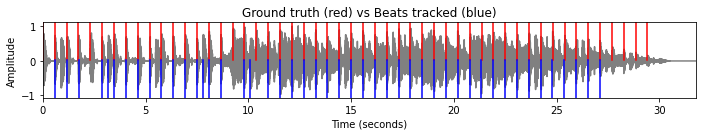

In [16]:
path_data = '../ballroom-annotations/'

# For now just testing with one
annotations_file = path_data+'Media-105611.beats'

def plot_play(true_beats, estimated_beats, x):
    # Audio player
    y = librosa.clicks(times=estimated_beats, sr=sr, length=len(x))
    ipd.display(ipd.Audio(x + y, rate=sr))

    # Plot audio
    t1 = np.arange(x.shape[0]) / sr
    plt.figure(figsize=(10, 2))
    plt.plot(t1, x, color='gray')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.xlim([t1[0], t1[-1]])
    plt.title('Ground truth (red) vs Beats tracked (blue)')
    plt.tight_layout()

    for b in true_beats:
       plt.axvline(b, ymin=0.5, color='r')
    for b in estimated_beats:
       plt.axvline(b, ymax=0.5, color='b')  

    
beat_annotations = np.genfromtxt(annotations_file, delimiter=' ')
true_beats = beat_annotations.transpose()[0]
plot_play(true_beats, estimated_beats, x)
mir_eval.beat.evaluate(true_beats, np.array(estimated_beats))

## Generalizing to datasets

In [9]:
# TODO